In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# create the stored files folder tr and tr_txt
# import shutil to copy image files
import shutil 

# read in training images
with open('dataset4/trainimages.txt','r') as f:
    #content = f.readlines()
    content = [line.rstrip('\n') for line in f]
    #print(content)
    for img in content:
        shutil.copy('dataset4/images/'+img,'dataset4/tr/')
        bbtxt = img.rstrip('.jpg') + '.txt'
        shutil.copy('dataset4/bounding_boxes/'+ bbtxt, 'dataset4/tr_txt/')
        #print(img)
        
print("All training images are copied into tr folder and bbox into tr_txt folder")

All training images are copied into tr folder and bbox into tr_txt folder


In [13]:
import imgaug as ia
from imgaug import augmenters as iaa
import skimage.io
import numpy as np
import skimage.color as color
from skimage.color import gray2rgb

In [14]:
def bboxSetupInImage(txtFile,img):
    """
    This is the function that reads in the bounding box files and then using imgaug to set up the bounding box on images
    
    :param txtFile: the txt file that store bounding box information 
    :param img: the image file variable to represent the img to be plotted bounding box on it 
    :return bbs: the image with bounding box in it
    """
    with open('dataset4/tr_txt/' + txtFile,'r') as f:
        content = [line.rstrip('\n') for line in f]
        iaBBoxList = []
        for bbline in content:
            bbox = bbline.split()
            #print(bbox[1])
            iaBBoxList.append(ia.BoundingBox(x1=float(bbox[2]), y1=float(bbox[1]), x2=float(bbox[4]), y2=float(bbox[3]),label = bbox[0]))
        bbs = ia.BoundingBoxesOnImage(iaBBoxList, shape=img.shape)
        return bbs

(1024, 1024)
(1024, 1024, 3)


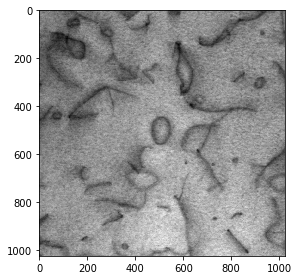

In [15]:
# Test on single image
img = '0501_300kx_1nm_clhaadf3_0006.jpg'
# Grayscale images must have shape (height, width, 1) each.
myimage = skimage.io.imread('dataset4/images/'+img).astype(np.uint8)
#myimage = myimage[:,:, np.newaxis]
#skimage.io.imshow(myimage)
#print(myimage.shape)

# gray2rgb() simply duplicates the gray values over the three color channels.
myimage = color.gray2rgb(myimage)
#print(myimage.shape)

bbs = bboxSetupInImage(img.rstrip('.jpg') + '.txt',myimage)
#print(bbs)

In [35]:
ia.seed(1)

# define data augmentation operations
seq = iaa.Sequential([
    iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
    # iaa.Affine(
    #    translate_px={"x": 40, "y": 60},
    #    scale=(0.5, 0.7)
    #),
    # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
    iaa.Fliplr(1.0), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
])


In [36]:
# Make our sequence deterministic.
# We can now apply it to the image and then to the BBs and it will
# lead to the same augmentations.
# IMPORTANT: Call this once PER BATCH, otherwise you will always get the exactly same augmentations for every batch!
seq_det = seq.to_deterministic()


In [37]:
# Augment BBs and images.
# As we only have one image and list of BBs, we use
# [image] and [bbs] to turn both into lists (batches) for the
# functions and then [0] to reverse that. In a real experiment, your
# variables would likely already be lists.
image_aug = seq_det.augment_images([myimage])[0]
bbs_aug = seq_det.augment_bounding_boxes([bbs])[0]

In [38]:
# print coordinates before/after augmentation (see below)
# use .x1_int, .y_int, ... to get integer coordinates
for i in range(len(bbs.bounding_boxes)):
    before = bbs.bounding_boxes[i]
    after = bbs_aug.bounding_boxes[i]
    print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
        i,
        before.x1, before.y1, before.x2, before.y2,
        after.x1, after.y1, after.x2, after.y2)
    )

# image with BBs before/after augmentation (shown below)
image_before = bbs.draw_on_image(myimage, thickness=2)
image_after = bbs_aug.draw_on_image(image_aug, thickness=2, color=[0, 0, 255])

BB 0: (474.0500, 444.1700, 550.0500, 557.1700) -> (472.9500, 444.1700, 548.9500, 557.1700)
BB 1: (895.3600, 278.0700, 942.3600, 322.0700) -> (80.6400, 278.0700, 127.6400, 322.0700)
BB 2: (168.5900, 647.8700, 211.5900, 710.8700) -> (811.4100, 647.8700, 854.4100, 710.8700)
BB 3: (117.4500, 31.2400, 169.4500, 67.2400) -> (853.5500, 31.2400, 905.5500, 67.2400)
BB 4: (261.6800, 76.6800, 306.6800, 112.6800) -> (716.3200, 76.6800, 761.3200, 112.6800)
BB 5: (55.6100, 424.8800, 95.6100, 453.8800) -> (927.3900, 424.8800, 967.3900, 453.8800)
BB 6: (622.9100, 386.3300, 650.9100, 412.3300) -> (372.0900, 386.3300, 400.0900, 412.3300)
BB 7: (657.1100, 578.0700, 671.1100, 595.0700) -> (351.8900, 578.0700, 365.8900, 595.0700)
BB 8: (177.1600, 942.4000, 203.1600, 960.4000) -> (819.8400, 942.4000, 845.8400, 960.4000)
BB 9: (816.5800, 259.4600, 858.5800, 296.4600) -> (164.4200, 259.4600, 206.4200, 296.4600)
BB 10: (643.2400, 344.0400, 690.2400, 392.0400) -> (332.7600, 344.0400, 379.7600, 392.0400)
BB 11: 

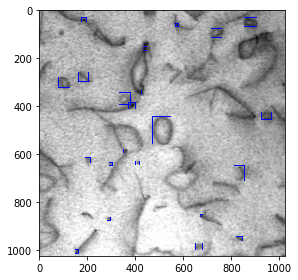

In [39]:
# plot and save figures before and after data augmentations

skimage.io.imshow(image_before)
skimage.io.imshow(image_after)

skimage.io.imsave("beforet.png",image_before)

skimage.io.imsave("after.png",image_after)

(256, 256, 3)
BoundingBoxesOnImage([BoundingBox(x1=65.0000, y1=100.0000, x2=200.0000, y2=150.0000, label=None), BoundingBox(x1=150.0000, y1=80.0000, x2=200.0000, y2=130.0000, label=None)], shape=(256, 256, 3))


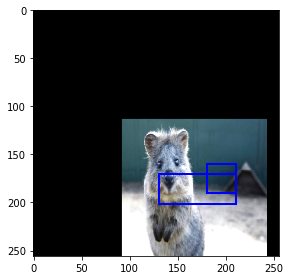

In [74]:
print(image.shape)
print(bbs)

# 'images' should be either a 4D numpy array of shape (N, height, width, channels)
# or a list of 3D numpy arrays, each having shape (height, width, channels).
# Grayscale images must have shape (height, width, 1) each.
# All images must have numpy's dtype uint8. Values are expected to be in range 0-255.

(1024, 1024)


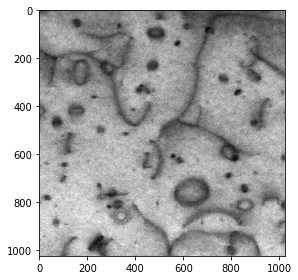

In [63]:
# Grayscale images must have shape (height, width, 1) each.
myimage = skimage.io.imread('dataset4/images/'+img).astype( np.uint8)

#myimage = myimage[:,:, np.newaxis]
skimage.io.imshow(myimage)
print(myimage.shape)

In [24]:
import os

In [20]:
os.getcwd()

'/Users/mingrenshen/PycharmProjects/imgaug'

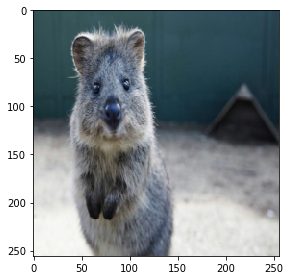

In [3]:
image = ia.quokka(size=(256, 256))
bbs = ia.BoundingBoxesOnImage([
    ia.BoundingBox(x1=65, y1=100, x2=200, y2=150),
    ia.BoundingBox(x1=150, y1=80, x2=200, y2=130)
], shape=image.shape)

skimage.io.imshow(image)

In [6]:
seq = iaa.Sequential([
    iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
    iaa.Affine(
        translate_px={"x": 40, "y": 60},
        scale=(0.5, 0.7)
    ) # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
])


In [7]:
# Make our sequence deterministic.
# We can now apply it to the image and then to the BBs and it will
# lead to the same augmentations.
# IMPORTANT: Call this once PER BATCH, otherwise you will always get the
# exactly same augmentations for every batch!
seq_det = seq.to_deterministic()


In [8]:
# Augment BBs and images.
# As we only have one image and list of BBs, we use
# [image] and [bbs] to turn both into lists (batches) for the
# functions and then [0] to reverse that. In a real experiment, your
# variables would likely already be lists.
image_aug = seq_det.augment_images([image])[0]
bbs_aug = seq_det.augment_bounding_boxes([bbs])[0]

In [9]:
# print coordinates before/after augmentation (see below)
# use .x1_int, .y_int, ... to get integer coordinates
for i in range(len(bbs.bounding_boxes)):
    before = bbs.bounding_boxes[i]
    after = bbs_aug.bounding_boxes[i]
    print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
        i,
        before.x1, before.y1, before.x2, before.y2,
        after.x1, after.y1, after.x2, after.y2)
    )



BB 0: (65.0000, 100.0000, 200.0000, 150.0000) -> (130.7524, 171.3311, 210.1272, 200.7291)
BB 1: (150.0000, 80.0000, 200.0000, 130.0000) -> (180.7291, 159.5718, 210.1272, 188.9699)


In [10]:
# image with BBs before/after augmentation (shown below)
image_before = bbs.draw_on_image(image, thickness=2)
image_after = bbs_aug.draw_on_image(image_aug, thickness=2, color=[0, 0, 255])

In [19]:
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

ia.seed(1)

# Example batch of images.
# The array has shape (32, 64, 64, 3) and dtype uint8.
images = np.array(
    [ia.quokka(size=(64, 64)) for _ in range(32)],
    dtype=np.uint8
)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

images_aug = seq.augment_images(images)

In [25]:
import matplotlib.pyplot as plt

In [26]:
from imgaug import augmenters as iaa
import numpy as np

images = np.random.randint(0, 255, (16, 128, 128, 3), dtype=np.uint8)
seq = iaa.Sequential([iaa.Fliplr(0.5), iaa.GaussianBlur((0, 3.0))])

# show an image with 8*8 augmented versions of image 0
seq.show_grid(images[0], cols=8, rows=8)

# Show an image with 8*8 augmented versions of image 0 and 8*8 augmented
# versions of image 1. The identical augmentations will be applied to
# image 0 and 1.
seq.show_grid([images[0], images[1]], cols=8, rows=8)

RuntimeError: Could not execute image viewer.

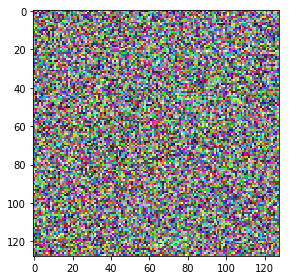

In [18]:
from scipy import misc
import skimage.io
import numpy as np
image = np.random.randint(0, 255, (128, 128, 3), dtype=np.uint8)
skimage.io.imshow(image)